In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.sql.warehouse.dir,file:/users/home/uwi14/Uditha/Assignment2/spark-warehouse
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.sql.shuffle.partitions,32
spark.app.startTime,1717461093155


In [3]:
# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')

In [53]:
# Write your imports and code here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window
from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, desc, count
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import sum, col
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
import random
from pyspark.sql.functions import sum, col, rand

In [5]:
#Other imports to be used locally

import datetime

import numpy as np
import scipy as sp
import pandas as pd

np.set_printoptions(edgeitems=5, threshold=100, precision=4)

In [6]:
# Determine ideal number of partitions

conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 32


# Song recommendations
### In this section you will use the Taste Profile dataset to develop a song recommendation service based on collaborative filtering.
### Collaborative filtering describes algorithms that generate songs recommendations for specific users based on the combined user-song play information from all users. These song recommendations are generated by embedding users and songs as numerical vectors in the same vector space, and selecting songs that are similar to the user based on cosine similarity.


# Q1 
### First it will be helpful to know more about the properties of the dataset before you being training
### the collaborative filtering model.


In [8]:
#firstly, load the taste profile dataset
schema_triplets = StructType([
    StructField("user_id", StringType(), True),
    StructField("song_id",StringType(), True),
    StructField("play_count", IntegerType(), True)
])

# Load triplets data from HDFS
triplets_new = spark.read.csv("/data/msd/tasteprofile/triplets.tsv/", sep = '\t', schema = schema_triplets).repartition(partitions)
triplets_new.cache()

print('\n')
print(f' The  triplets table has {triplets_new.count()} rows.')
show_as_html(triplets_new, 5 )



 The  triplets table has 48373586 rows.


,user_id,song_id,play_count
0,ae4d21862db75b3cdbd9b400bbba647fc7e32a18,SOOCMIB12A8C13E465,5
1,bc2066eda369e411b0a64255874bc38dbb30aa8e,SOOXDVF12A6D4FB4AD,1
2,2bf302479a335436d97c248cb00019d0cceae93b,SOFBOXR12A6310F0FC,3
3,ba30b82fb562ac0ea0f4afaba54329d4af751af3,SOPIBLV12A8C136C2A,6
4,80779cf1be0cf7ea2adeaa6b92572a460ab7b853,SOQCIQX12A8C13B272,2


In [9]:
num_song_unique = triplets_new.select(F.col('song_id')).distinct().count()
num_user_unique = triplets_new.select(F.col('user_id')).distinct().count()

print(f'There are {num_song_unique} unique songs.')
print(f'There are {num_user_unique} unique users.')

There are 384546 unique songs.
There are 1019318 unique users.


# (c) 
### How many different songs has the most active user played?
### What is this as a percentage of the total number of unique songs in the dataset?

In [10]:
# most active user
most_active_users = triplets_new.groupBy("user_id").sum("play_count").withColumnRenamed("sum(play_count)", "total_play_count").orderBy(desc("total_play_count"))
most_active_users.show()

+--------------------+----------------+
|             user_id|total_play_count|
+--------------------+----------------+
|093cb74eb3c517c51...|           13132|
|119b7c88d58d0c6eb...|            9884|
|3fa44653315697f42...|            8210|
|a2679496cd0af9779...|            7015|
|d7d2d888ae04d16e9...|            6494|
|4ae01afa8f2430ea0...|            6472|
|b7c24f770be6b8028...|            6150|
|113255a012b2affea...|            5656|
|6d625c6557df84b60...|            5620|
|99ac3d883681e21ea...|            5602|
|281deab3afccc9062...|            5579|
|3325fe1d8da7b13dd...|            5465|
|6b36f65d2eb5579a8...|            5381|
|c1255748c06ee3f64...|            5288|
|ec6dfcf19485cb011...|            5260|
|18c1dd917693fd929...|            5073|
|3b93435988354b188...|            4840|
|6a58f480d522814c0...|            4764|
|4be305e02f4e72dad...|            4580|
|4e73d9e058d2b1f2d...|            4494|
+--------------------+----------------+
only showing top 20 rows



In [11]:
most_active_user = most_active_users.first()
print(f"The most active user is {most_active_user['user_id']} with a play count of {most_active_user['total_play_count']}.")

The most active user is 093cb74eb3c517c5179ae24caf0ebec51b24d2a2 with a play count of 13132.


In [12]:
most_active_user_id = "093cb74eb3c517c5179ae24caf0ebec51b24d2a2"
most_active_user_df = triplets_new.filter(col("user_id") == most_active_user_id)

# Show the filtered DataFrame
most_active_user_df.show()

+--------------------+------------------+----------+
|             user_id|           song_id|play_count|
+--------------------+------------------+----------+
|093cb74eb3c517c51...|SOPIIMZ12AB018B957|        30|
|093cb74eb3c517c51...|SOUNZHU12A8AE47481|         8|
|093cb74eb3c517c51...|SOMYFIR12A8C13801C|         2|
|093cb74eb3c517c51...|SOEKNMO12AF72A1918|        25|
|093cb74eb3c517c51...|SOAQMNM12AB0188D7A|         1|
|093cb74eb3c517c51...|SOKRAMY12A8C140804|         2|
|093cb74eb3c517c51...|SOCGALN12A8C142C98|         2|
|093cb74eb3c517c51...|SOXFSTR12A8AE463B0|         3|
|093cb74eb3c517c51...|SOBFSES12A8C140597|         2|
|093cb74eb3c517c51...|SODBJOM12A8C1426B9|        22|
|093cb74eb3c517c51...|SOOHOAE12AF729D88B|       152|
|093cb74eb3c517c51...|SODNMQU12AAA15FB31|         3|
|093cb74eb3c517c51...|SONPZTQ12A8C13865E|        32|
|093cb74eb3c517c51...|SONMVKD12A6D4F6D10|        16|
|093cb74eb3c517c51...|SODTHYD12A6D4F9A12|       158|
|093cb74eb3c517c51...|SOLPAOF12A8C13698E|     

In [13]:
most_active_user_unique_songs_count = most_active_user_df.select("song_id").distinct().count()

# Show the result
print(f"The number of unique songs for user ID {most_active_user_id} is {most_active_user_unique_songs_count}.")

The number of unique songs for user ID 093cb74eb3c517c5179ae24caf0ebec51b24d2a2 is 202.


In [14]:
percentage = (most_active_user_unique_songs_count/num_song_unique) * 100
print(f'This is as a {percentage:.3f}% percent of the total number of unique songs.')


This is as a 0.053% percent of the total number of unique songs.


## (d) Visualize the distribution of song popularity and the distribution of user activity by collecting
### the counts of user plays per song and the counts of song plays per user respectively, and
### describe the shape of the distributions.

In [15]:
# Compute song popularity distribution (counts of user plays per song)
song_popularity_df = triplets_new.groupBy("song_id").agg(count("user_id").alias("users_per_song")).orderBy(desc("users_per_song"))
song_popularity_df.show()

+------------------+--------------+
|           song_id|users_per_song|
+------------------+--------------+
|SOFRQTD12A81C233C0|        110479|
|SOAUWYT12A81C206F1|         90476|
|SOAXGDH12A8C13F8A1|         90444|
|SOBONKR12A58A7A7E0|         84000|
|SOSXLTC12AF72A7F54|         80656|
|SONYKOW12AB01849C9|         78353|
|SOEGIYH12A6D4FC0E3|         69487|
|SOLFXKT12AB017E3E0|         64229|
|SODJWHY12A8C142CCE|         63809|
|SOFLJQZ12A6D4FADA6|         58610|
|SOUSMXX12AB0185C24|         53260|
|SOWCKVR12A8C142411|         52080|
|SOUVTSM12AC468F6A7|         51022|
|SOTWNDJ12A8C143984|         47011|
|SOPUCYA12A8C13A694|         46078|
|SOHTKMO12AB01843B0|         46077|
|SOKLRPJ12A8C13C3FE|         45495|
|SOCVTLJ12A6310F0FD|         42535|
|SOPPROJ12AB0184E18|         41811|
|SOBOUPA12A6D4F81F1|         41093|
+------------------+--------------+
only showing top 20 rows



## Number of Users per song

In [16]:
song_popularity_pd = song_popularity_df.toPandas()


In [17]:
song_popularity_pd.head(5)

,song_id,users_per_song
0,SOFRQTD12A81C233C0,110479
1,SOAUWYT12A81C206F1,90476
2,SOAXGDH12A8C13F8A1,90444
3,SOBONKR12A58A7A7E0,84000
4,SOSXLTC12AF72A7F54,80656


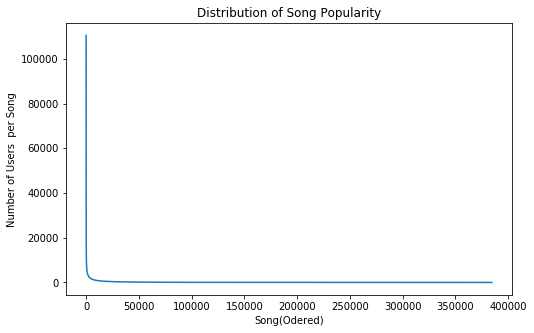

In [18]:

plt.figure(figsize=(8,5))
plt.plot(song_popularity_pd['users_per_song'])
plt.title('Distribution of Song Popularity')
plt.xlabel('Song(Odered)')
plt.ylabel('Number of Users  per Song')
plt.show() 

## Number of Plays per song

In [19]:
# Compute song popularity distribution (counts of user plays per song)
song_play_df = triplets_new.groupBy("song_id").agg(sum("play_count").alias("total_plays_per_song")).orderBy(desc("total_plays_per_song"))
song_play_df.show()

+------------------+--------------------+
|           song_id|total_plays_per_song|
+------------------+--------------------+
|SOBONKR12A58A7A7E0|              726885|
|SOAUWYT12A81C206F1|              648239|
|SOSXLTC12AF72A7F54|              527893|
|SOFRQTD12A81C233C0|              425463|
|SOEGIYH12A6D4FC0E3|              389880|
|SOAXGDH12A8C13F8A1|              356533|
|SONYKOW12AB01849C9|              292642|
|SOPUCYA12A8C13A694|              274627|
|SOUFTBI12AB0183F65|              268353|
|SOVDSJC12A58A7A271|              244730|
|SOOFYTN12A6D4F9B35|              241669|
|SOHTKMO12AB01843B0|              236494|
|SOBOUPA12A6D4F81F1|              225652|
|SODJWHY12A8C142CCE|              209212|
|SOLFXKT12AB017E3E0|              197181|
|SOTCMDJ12A6D4F8528|              192884|
|SOFLJQZ12A6D4FADA6|              185653|
|SOTWNDJ12A8C143984|              174080|
|SOUNZHU12A8AE47481|              158636|
|SOUVTSM12AC468F6A7|              155717|
+------------------+--------------

In [20]:
song_play_pd = song_play_df.toPandas()
song_play_pd.head(5)

,song_id,total_plays_per_song
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880


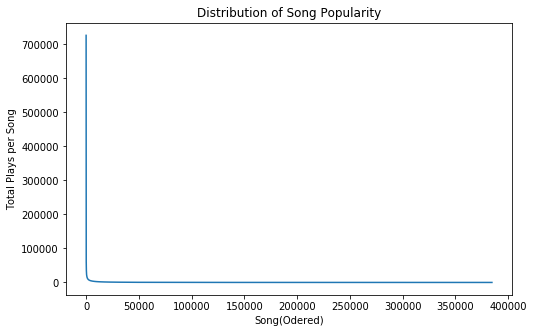

In [21]:
plt.figure(figsize=(8,5))
plt.plot(song_play_pd['total_plays_per_song'])
plt.title('Distribution of Song Popularity')
plt.xlabel('Song(Odered)')
plt.ylabel('Total Plays per Song')
plt.show() 

## Number of Plays per User

In [22]:
# Compute user activity distribution (counts of song plays per user)
user_activity_df = triplets_new.groupBy("user_id").agg(count("song_id").alias("song_plays_per_user")).orderBy(desc("song_plays_per_user"))
user_activity_df.show()

+--------------------+-------------------+
|             user_id|song_plays_per_user|
+--------------------+-------------------+
|ec6dfcf19485cb011...|               4400|
|8cb51abc6bf8ea293...|               1651|
|fef771ab021c20018...|               1614|
|5a3417a1955d91364...|               1604|
|c1255748c06ee3f64...|               1566|
|4e73d9e058d2b1f2d...|               1544|
|cbc7bddbe3b2f59fd...|               1536|
|96f7b4f800cafef33...|               1491|
|119b7c88d58d0c6eb...|               1451|
|b7c24f770be6b8028...|               1446|
|6d625c6557df84b60...|               1398|
|33a1286454a3cff06...|               1373|
|a05e548059abb1f77...|               1370|
|d7d2d888ae04d16e9...|               1319|
|7e543508a213f4f22...|               1267|
|4e11f45d732f48617...|               1257|
|1aa4fd215aadb1609...|               1254|
|0c2932cb475b83b61...|               1245|
|db6a78c78c9239aba...|               1241|
|18765abd13462c176...|               1236|
+----------

In [23]:
user_activity_pd = user_activity_df.toPandas()

In [24]:
user_activity_pd.head(5)

,user_id,song_plays_per_user
0,ec6dfcf19485cb011e0b22637075037aae34cf26,4400
1,8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc,1651
2,fef771ab021c200187a419f5e55311390f850a50,1614
3,5a3417a1955d9136413e0d293cd36497f5e00238,1604
4,c1255748c06ee3f6440c51c439446886c7807095,1566


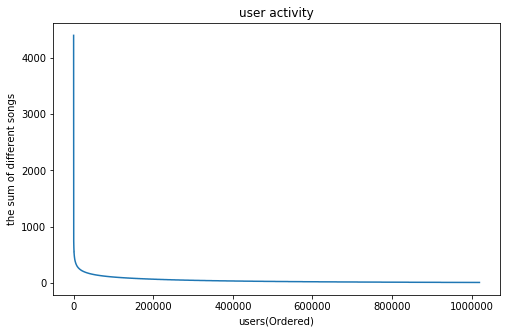

In [25]:
plt.figure(figsize=(8,5))
plt.plot(user_activity_pd['song_plays_per_user'])
plt.title( "user activity")
plt.xlabel('users(Ordered)')
plt.ylabel('the sum of different songs')
plt.show() 

In [26]:
user_play_df = triplets_new.groupBy("user_id").agg(sum("play_count").alias("total_plays_per_user")).orderBy(desc("total_plays_per_user"))
user_play_df.show()

+--------------------+--------------------+
|             user_id|total_plays_per_user|
+--------------------+--------------------+
|093cb74eb3c517c51...|               13132|
|119b7c88d58d0c6eb...|                9884|
|3fa44653315697f42...|                8210|
|a2679496cd0af9779...|                7015|
|d7d2d888ae04d16e9...|                6494|
|4ae01afa8f2430ea0...|                6472|
|b7c24f770be6b8028...|                6150|
|113255a012b2affea...|                5656|
|6d625c6557df84b60...|                5620|
|99ac3d883681e21ea...|                5602|
|281deab3afccc9062...|                5579|
|3325fe1d8da7b13dd...|                5465|
|6b36f65d2eb5579a8...|                5381|
|c1255748c06ee3f64...|                5288|
|ec6dfcf19485cb011...|                5260|
|18c1dd917693fd929...|                5073|
|3b93435988354b188...|                4840|
|6a58f480d522814c0...|                4764|
|4be305e02f4e72dad...|                4580|
|4e73d9e058d2b1f2d...|          

In [27]:
user_play_pd = user_play_df.toPandas()
user_play_pd.head(5)

,user_id,total_plays_per_user
0,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
1,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
2,3fa44653315697f42410a30cb766a4eb102080bb,8210
3,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
4,d7d2d888ae04d16e994d6964214a1de81392ee04,6494


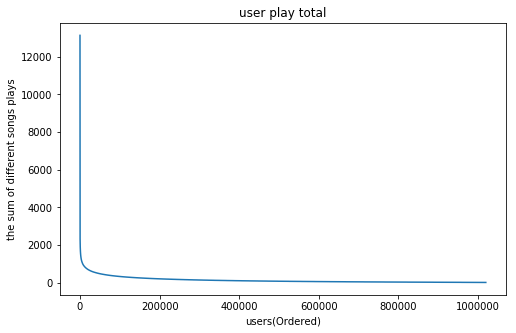

In [28]:
plt.figure(figsize=(8,5))
plt.plot(user_play_pd['total_plays_per_user'])
plt.title( "user play total")
plt.xlabel('users(Ordered)')
plt.ylabel('the sum of different songs plays')
plt.show() 

## Q2 
### Next you will train the collaborative filtering model.


### (a)
### Collaborative filtering determines similar users and songs based on their combined play history. Songs which have been played only a few times and users who have only listened to a few songs will not contribute much information and are unlikely to improve the model. Create a clean dataset of user-song plays by removing songs which have been played less than N times and users who have listened to fewer than M songs in total. Choose sensible values for N and M, taking into account the total number of users and songs.


In [29]:
#Firstly, analysis these two distributions
print('distribution of song popularity')
with pd.option_context('display.float_format', '{:0.2f}'.format):
   print(song_play_pd.describe())

print('distribution of user activity')
with pd.option_context('display.float_format', '{:0.2f}'.format):
   print(user_play_pd.describe())

distribution of song popularity
       total_plays_per_song
count             384546.00
mean                 360.63
std                 3256.81
min                    1.00
25%                    8.00
50%                   32.00
75%                  133.00
max               726885.00
distribution of user activity
       total_plays_per_user
count            1019318.00
mean                 136.05
std                  184.53
min                   10.00
25%                   34.00
50%                   73.00
75%                  163.00
max                13132.00


In [43]:
song_popularity_pd_filtered = song_play_pd[song_play_pd['total_plays_per_song']>360]
with pd.option_context('display.float_format', '{:0.2f}'.format):
   print(song_popularity_pd_filtered.describe())

user_activity_pd_filtered = user_play_pd[user_play_pd['total_plays_per_user']>136]
with pd.option_context('display.float_format', '{:0.2f}'.format):
   print(user_activity_pd_filtered.describe())

       total_plays_per_song
count              52491.00
mean                2295.66
std                 8563.55
min                  361.00
25%                  539.00
50%                  892.00
75%                 1896.00
max               726885.00
       total_plays_per_user
count             306169.00
mean                 325.91
std                  243.19
min                  137.00
25%                  179.00
50%                  247.00
75%                  380.00
max                13132.00


In [44]:
song_popularity_filtered = spark.createDataFrame(song_popularity_pd_filtered)
stringIndexer_songs = StringIndexer(inputCol="song_id", outputCol="song_code", stringOrderType="frequencyDesc")
song_fit = stringIndexer_songs.fit(song_popularity_filtered)
song_popularity_filtered = song_fit.transform(song_popularity_filtered)

song_popularity_filtered.show(5)

+------------------+--------------------+---------+
|           song_id|total_plays_per_song|song_code|
+------------------+--------------------+---------+
|SOBONKR12A58A7A7E0|              726885|   3343.0|
|SOAUWYT12A81C206F1|              648239|   1746.0|
|SOSXLTC12AF72A7F54|              527893|  39094.0|
|SOFRQTD12A81C233C0|              425463|  12183.0|
|SOEGIYH12A6D4FC0E3|              389880|   9103.0|
+------------------+--------------------+---------+
only showing top 5 rows



In [45]:
user_activity_filtered = spark.createDataFrame(user_activity_pd_filtered)
stringIndexer_songs = StringIndexer(inputCol="user_id", outputCol="user_code", stringOrderType="frequencyDesc")
user_fit = stringIndexer_songs.fit(user_activity_filtered)
user_activity_filtered = user_fit.transform(user_activity_filtered)
user_activity_filtered.show(5)

+--------------------+--------------------+---------+
|             user_id|total_plays_per_user|user_code|
+--------------------+--------------------+---------+
|093cb74eb3c517c51...|               13132|  10899.0|
|119b7c88d58d0c6eb...|                9884|  20650.0|
|3fa44653315697f42...|                8210|  75483.0|
|a2679496cd0af9779...|                7015| 193771.0|
|d7d2d888ae04d16e9...|                6494| 257786.0|
+--------------------+--------------------+---------+
only showing top 5 rows



In [46]:
# merge
triplets_merge = triplets_new.join(song_popularity_filtered, on='song_id',how='left')\
.filter(F.col('song_code').isNotNull())\
.join(user_activity_filtered, on='user_id',how='left')\
.filter(F.col('user_code').isNotNull())\
.drop( 'total_plays_per_song', 'total_plays_per_user' )
triplets_merge.show(10)

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|0008320d84f011147...|SOBNZTU12AB0188907|         9|   3302.0|     27.0|
|0008320d84f011147...|SOXSTRR12AB018DB42|         1|  48287.0|     27.0|
|0008320d84f011147...|SOXGMFD12A8C132B83|         5|  47370.0|     27.0|
|0008320d84f011147...|SOMTZOO12A58A7BF5F|         2|  26922.0|     27.0|
|0008320d84f011147...|SOEZFIG12AF729D52E|         3|  10666.0|     27.0|
|0008320d84f011147...|SOISKOP12A6310E2B5|        14|  18557.0|     27.0|
|0008320d84f011147...|SOOHRZZ12A8C1334B8|         5|  30100.0|     27.0|
|0008320d84f011147...|SOHCWEJ12A8C13EBD9|         1|  15254.0|     27.0|
|0008320d84f011147...|SOMQSOC12A8C133BED|         9|  26658.0|     27.0|
|0008320d84f011147...|SODWUCN12A6701D259|         5|   8307.0|     27.0|
+--------------------+------------------+----------

# (b)

### Split the dataset into training and test sets. The test set should contain at least 25% of the plays in total. Note that due to the nature of the collaborative filtering model, you must ensure that every user in the test set has some user-song plays in the training set as well. Explain why this is required and how you have done this while keeping the selection as random as possible.

In [48]:
# Calculate the total play count
total_play_count = triplets_merge.agg(F.sum("play_count")).collect()[0][0]

In [49]:
# Determine the threshold for the test set (25% of total play count)
test_play_count_threshold = total_play_count * 0.25
test_play_count_threshold

21664766.75

In [50]:
# Randomly split the dataset into initial training and test sets (75% train, 25% test)
train_df, test_df = triplets_merge.randomSplit([0.75, 0.25], seed=42)

In [51]:
# Calculate the play count in the test set
test_play_count = test_df.agg(sum("play_count")).collect()[0][0]

In [52]:
test_play_count

21691543

In [54]:
columns = ["user_id", "song_id", "play_count", "song_code", "user_code"]

In [55]:
# Adjust the test set if it doesn't meet the play count threshold
while test_play_count < test_play_count_threshold:
    # Calculate remaining play count needed
    remaining_play_count_needed = test_play_count_threshold - test_play_count
    
    # Take random rows from the training set until the threshold is met
    additional_rows = train_df.orderBy(rand()).limit(10000).collect()  
    
    # Convert additional rows to DataFrame
    additional_rows_df = spark.createDataFrame(additional_rows, columns)
    
    # Add these rows to the test set
    test_df = test_df.union(additional_rows_df)
    
    # Remove these rows from the training set
    train_df = train_df.subtract(additional_rows_df)

In [56]:
test_play_count = test_df.agg(sum("play_count")).collect()[0][0]

print(f"Test set actual play count: {test_play_count}")

Test set actual play count: 21691543


In [57]:
test_percentage = (test_play_count /total_play_count) * 100
print(f'The test set contains {test_percentage}% of the plays in total.')

The test set contains 25.03089838250855% of the plays in total.


In [83]:
# Show the first few rows of each set
train_df.show(5)
test_df.show(5)

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|0008320d84f011147...|SOBNZTU12AB0188907|       9.0|   3302.0|     27.0|
|0008320d84f011147...|SOBPHXV12A6D4F9FD0|       6.0|   3409.0|     27.0|
|0008320d84f011147...|SODKKNZ12A8C13E383|       9.0|   7309.0|     27.0|
|0008320d84f011147...|SODWUCN12A6701D259|       5.0|   8307.0|     27.0|
|0008320d84f011147...|SOEZFIG12AF729D52E|       3.0|  10666.0|     27.0|
+--------------------+------------------+----------+---------+---------+
only showing top 5 rows

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|0008320d84f011147...|SOCDTEX12AB017CA4D|         1|   4627.0|     27.0|
|0008320d84f011147...|SOGN

In [84]:
train_df.cache()
test_df.cache()

DataFrame[user_id: string, song_id: string, play_count: int, song_code: double, user_code: double]

In [93]:
test_anti_df = test_df.join(train_df, on='user_id',how='leftanti')
test_anti_df.show()

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|1ce85c735fc01d061...|SOXOOCT12AF72A1027|         7|  47965.0|  34261.0|
|5d8ab97b05db2ed5f...|SOQADZS12A670202F9|         1|  33513.0| 111504.0|
|c159212d39011b609...|SOEVGLT12A6D4F7A4E|         9|  10305.0| 230818.0|
+--------------------+------------------+----------+---------+---------+



Since there are only 3 users which are not in the training data, it is ignored

In [94]:
test_new_df = test_df.join(test_anti_df, on='user_id',how='leftanti')
test_new_df.show()

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|0008320d84f011147...|SOCDTEX12AB017CA4D|         1|   4627.0|     27.0|
|0008320d84f011147...|SOGNXXS12AB0184504|         1|  14050.0|     27.0|
|0008320d84f011147...|SOHZPYD12AF72A12E2|         1|  17074.0|     27.0|
|0008320d84f011147...|SOISKOP12A6310E2B5|        14|  18557.0|     27.0|
|0008320d84f011147...|SOMTZOO12A58A7BF5F|         2|  26922.0|     27.0|
|0008320d84f011147...|SOOYIHH12AB018C2C7|         1|  31377.0|     27.0|
|0008320d84f011147...|SORWLJM12A6D4F9C0C|         7|  37057.0|     27.0|
|0008320d84f011147...|SOXLOQG12AF72A2D55|         2|  47750.0|     27.0|
|0008320d84f011147...|SOXSTRR12AB018DB42|         1|  48287.0|     27.0|
|0010d591497880a8f...|SOATQYE12A6D4F8167|         7|   1643.0|     68.0|
|0010d591497880a8f...|SOBVXWT12AB018EEC4|         1

In [95]:
# Calculate the play count in the test set
test_play_count_new = test_new_df.agg(sum("play_count")).collect()[0][0]

print(f"Test set actual play count New: {test_play_count_new}")

Test set actual play count New: 21691526


# (c) 
### Use the spark.ml library to train an implicit matrix factorization model using Alternating Least Squares (ALS).


In [60]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import DoubleType

# Cast "play_count" 
train_df = train_df.withColumn("play_count", train_df["play_count"].cast(DoubleType()))


als = ALS(maxIter=5, regParam=0.01, userCol="user_code", itemCol="song_code", ratingCol="play_count", 
          implicitPrefs=True, coldStartStrategy="drop")

# training 
als_model = als.fit(train_df)

# (d) 
### Select a few of the users from the test set by hand and use the model to generate some recommendations. Compare these recommendations to the songs the user has actually played. Comment on the effectiveness of the collaborative filtering model.


### User1 
User Code = 28.0
user_id = 

In [98]:
user_code = '28.0'
user_1 = test_df.select(F.col("*")).filter(F.col("user_code") == user_code)
user_1.cache()

user_1.show(21)

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|0008e355930792eb1...|SOADCFY12A6310E353|         1|    245.0|     28.0|
|0008e355930792eb1...|SOCBSPP12A6D4F711C|         4|   4497.0|     28.0|
|0008e355930792eb1...|SOCCXPY12A6D4F4773|         1|   4570.0|     28.0|
|0008e355930792eb1...|SOCYOTN12A8C13A4B1|         2|   6293.0|     28.0|
|0008e355930792eb1...|SODTYBO12A58A7B657|         3|   8088.0|     28.0|
|0008e355930792eb1...|SOGJWEA12A8151BD76|         1|  13724.0|     28.0|
|0008e355930792eb1...|SOICTOM12A6D4FCE8F|         1|  17331.0|     28.0|
|0008e355930792eb1...|SOKDIKJ12A8C13C707|         1|  21513.0|     28.0|
|0008e355930792eb1...|SOKQZYZ12A58A7767E|         2|  22602.0|     28.0|
|0008e355930792eb1...|SOLIQLA12A67AD867B|         1|  24037.0|     28.0|
|0008e355930792eb1...|SOMFTUN12A6D4F60A5|         5

In [62]:
# Predict relevance scores
pred_user_1 = als_model.transform(user_1)
pred_user_1.cache()

pred_user_1.printSchema()
pred_user_1.show(21)

root
 |-- user_id: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- play_count: integer (nullable = true)
 |-- song_code: double (nullable = true)
 |-- user_code: double (nullable = true)
 |-- prediction: float (nullable = false)

+--------------------+------------------+----------+---------+---------+------------+
|             user_id|           song_id|play_count|song_code|user_code|  prediction|
+--------------------+------------------+----------+---------+---------+------------+
|0008e355930792eb1...|SOOTEVS12A58A7FCDA|         1|  30963.0|     28.0| 0.028154463|
|0008e355930792eb1...|SOSDSUB12A6D4F5DC9|        10|  37565.0|     28.0| 0.018371265|
|0008e355930792eb1...|SOYUPVH12A6310DBBF|         1|  50263.0|     28.0|0.0151317045|
|0008e355930792eb1...|SOKQZYZ12A58A7767E|         2|  22602.0|     28.0| 0.051790275|
|0008e355930792eb1...|SOMNGMO12A6702187E|         2|  26414.0|     28.0|  0.02953531|
|0008e355930792eb1...|SOCCXPY12A6D4F4773|         1|   4570.0

In [157]:
# Generate recommendations

k = 20

recommendations_1 = als_model.recommendForAllUsers(k)

recommendations_1.printSchema()
recommendations_1.cache()
recommendations_1.show()

root
 |-- user_code: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- song_code: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)

+---------+--------------------+
|user_code|     recommendations|
+---------+--------------------+
|       12|[{25538, 0.246382...|
|       18|[{28086, 0.561619...|
|       38|[{39480, 0.035018...|
|       70|[{1951, 0.8072039...|
|       93|[{29997, 0.058395...|
|      190|[{39094, 0.571591...|
|      218|[{22204, 0.389838...|
|      273|[{31577, 0.649114...|
|      300|[{1951, 0.0524410...|
|      340|[{22204, 0.363937...|
|      343|[{39094, 0.524612...|
|      412|[{26447, 0.463276...|
|      434|[{29358, 0.537665...|
|      475|[{1951, 0.0929809...|
|      536|[{1694, 0.1019288...|
|      585|[{5187, 0.6244483...|
|      600|[{12183, 1.255048...|
|      611|[{1951, 0.2264583...|
|      615|[{40884, 0.196681...|
|      619|[{40276, 0.211070...|

In [158]:
# Collect and sort relevant items in order of descending relevance 

relevant_1 = (
    user_1
    .groupBy("user_code")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("play_count"),
                F.col("song_code"),
            )
        ))).alias("relevant")
    )
)
relevant_1.printSchema()
relevant_1.cache()
relevant_1.show()

root
 |-- user_code: double (nullable = true)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- play_count: integer (nullable = true)
 |    |    |-- song_code: double (nullable = true)

+---------+--------------------+
|user_code|            relevant|
+---------+--------------------+
|     28.0|[{10, 37565.0}, {...|
+---------+--------------------+



In [159]:
# Merge recommendations 

comparison_1 = (
    recommendations_1
    .select(
        F.col("user_code"),
        F.col("recommendations.song_code").alias("recommendations").astype(ArrayType(IntegerType())),
    )
    .join(
        relevant_1
        .select(
            F.col("user_code"),
            F.col("relevant.song_code").alias("relevant").astype(ArrayType(IntegerType())),
        ),
        on="user_code",
        how="inner"
    )
)
comparison_1.cache()

comparison_1.printSchema()
show_as_html(comparison_1)

root
 |-- user_code: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: integer (containsNull = true)



,user_code,recommendations,relevant
0,28,"[7268, 23781, 12183, 29358, 45151, 6064, 47306...","[37565, 25849, 25831, 4497, 43637, 8088, 26414..."


In [160]:
comparison_1_p = comparison_1.toPandas()

In [162]:

# Assuming comparison_1_p is already defined and contains the necessary data
comparison_1_p.columns

# Extract and clean the recommendations and relevant columns
list_recomd = pd.DataFrame(list(str(comparison_1_p.loc[0, 'recommendations']).replace('[', '').replace(']', '').split(',')), columns=['list_recomd'])
list_test = pd.DataFrame(list(str(comparison_1_p.loc[0, 'relevant']).replace('[', '').replace(']', '').split(',')), columns=['list_test'])

# Ensure the data types are consistent (e.g., convert to integers)
list_recomd['list_recomd'] = list_recomd['list_recomd'].astype(int)
list_test['list_test'] = list_test['list_test'].astype(int)

# Concatenate the DataFrames
compare_1 = pd.concat([list_recomd, list_test], axis=1)


# Convert the pandas DataFrame to a PySpark DataFrame
compare_1_spark = spark.createDataFrame(compare_1)
compare_1_spark =  compare_1_spark.dropna()

# Show the PySpark DataFrame
compare_1_spark.show(10)



+-----------+---------+
|list_recomd|list_test|
+-----------+---------+
|       7268|  37565.0|
|      23781|  25849.0|
|      12183|  25831.0|
|      29358|   4497.0|
|      45151|  43637.0|
|       6064|   8088.0|
|      47306|  26414.0|
|       3304|  22602.0|
|      22877|   6293.0|
|      37468|  50263.0|
+-----------+---------+
only showing top 10 rows



### loading the main summary data  in order to find the song details 

In [110]:
Main_Summary = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("hdfs:///data/msd/main/summary/*.csv.gz")
)
Main_Summary.show(10)

+----------------+-----------------+-------------------+-------------------+------------------+---------------+--------------------+----------------+--------------------+--------------------+---------------+-----+----------------+-------------------+--------------------+------------------+------------------+------------------+--------------------+----------------+
|analyzer_version|artist_7digitalid| artist_familiarity|  artist_hotttnesss|         artist_id|artist_latitude|     artist_location|artist_longitude|         artist_mbid|         artist_name|artist_playmeid|genre|idx_artist_terms|idx_similar_artists|             release|release_7digitalid|   song_hotttnesss|           song_id|               title|track_7digitalid|
+----------------+-----------------+-------------------+-------------------+------------------+---------------+--------------------+----------------+--------------------+--------------------+---------------+-----+----------------+-------------------+----------------

In [111]:
Main_Summary = Main_Summary.select("song_id","title","artist_name","genre")
Main_Summary.show(10)

+------------------+--------------------+--------------------+-----+
|           song_id|               title|         artist_name|genre|
+------------------+--------------------+--------------------+-----+
|SOQMMHC12AB0180CB8|        Silent Night|    Faster Pussy cat| null|
|SOVFVAK12A8C1350D9|         Tanssi vaan|    Karkkiautomaatti| null|
|SOGTUKN12AB017F4F1|   No One Could Ever|      Hudson Mohawke| null|
|SOBNYVR12A8C13558C|       Si Vos Querés|         Yerba Brava| null|
|SOHSBXH12A8C13B0DF|    Tangle Of Aspens|          Der Mystic| null|
|SOZVAPQ12A8C13B63C|"Symphony No. 1 G...|    David Montgomery| null|
|SOQVRHI12A6D4FB2D7|    We Have Got Love|  Sasha / Turbulence| null|
|SOEYRFT12AB018936C|   2 Da Beat Ch'yall|          Kris Kross| null|
|SOPMIYT12A6D4F851E|             Goodbye|        Joseph Locke| null|
|SOJCFMH12A8C13B0C2|Mama_ mama can't ...|The Sun Harbor's ...| null|
+------------------+--------------------+--------------------+-----+
only showing top 10 rows



In [114]:
triplets_merge.show(10)

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|0008320d84f011147...|SOIYQUA12A8AE46860|         5|  19037.0|     27.0|
|0008320d84f011147...|SOIZFTE12AB0186842|         4|  19090.0|     27.0|
|0008320d84f011147...|SOCDTEX12AB017CA4D|         1|   4627.0|     27.0|
|0008320d84f011147...|SONXXJJ12AAF3B3A9B|         2|  29311.0|     27.0|
|0008320d84f011147...|SOMTZOO12A58A7BF5F|         2|  26922.0|     27.0|
|0008320d84f011147...|SOHCWEJ12A8C13EBD9|         1|  15254.0|     27.0|
|0008320d84f011147...|SOMQSOC12A8C133BED|         9|  26658.0|     27.0|
|0008320d84f011147...|SORWLJM12A6D4F9C0C|         7|  37057.0|     27.0|
|0008320d84f011147...|SOUFTBI12AB0183F65|        30|  41615.0|     27.0|
|0008320d84f011147...|SOVIEIL12A6D4F7D84|         1|  43671.0|     27.0|
+--------------------+------------------+----------

In [163]:
# Join the dataframes on the song_code with list_recomd
recommendation_join = compare_1_spark.join(triplets_merge, compare_1_spark["list_recomd"] == triplets_merge["song_code"], "left").select("list_recomd", "song_id").distinct()

# Join the dataframes on the song_code with list_test
test_join = compare_1_spark.join(triplets_merge, compare_1_spark["list_test"] == triplets_merge["song_code"], "left").select("list_test", "song_id").distinct()

# Show the results
recommendation_join.show()
test_join.show()

+-----------+------------------+
|list_recomd|           song_id|
+-----------+------------------+
|      45151|SOWCKVR12A8C142411|
|      25139|SOLWZVR12AB01849C6|
|       6064|SOCVTLJ12A6310F0FD|
|      24723|SOLRGVL12A8C143BC3|
|      29358|SONYKOW12AB01849C9|
|      24265|SOLLNTU12A6701CFDC|
|      42557|SOUSMXX12AB0185C24|
|      11523|SOFKABN12A8AE476C6|
|       3304|SOBOAFP12A8C131F36|
|      37468|SOSCIZP12AB0181D2F|
|      12183|SOFRQTD12A81C233C0|
|      23781|SOLFXKT12AB017E3E0|
|      30228|SOOJJCT12A6310E1C0|
|       7268|SODJWHY12A8C142CCE|
|      28086|SONIQRE12AF72A2B02|
|      22204|SOKLRPJ12A8C13C3FE|
|      47306|SOXFPND12AB017C9D1|
|      32964|SOPTLQL12AB018D56F|
|      22877|SOKUPAO12AB018D576|
+-----------+------------------+

+---------+------------------+
|list_test|           song_id|
+---------+------------------+
|  17331.0|SOICTOM12A6D4FCE8F|
|  21513.0|SOKDIKJ12A8C13C707|
|  43637.0|SOVHUFT12AAA15FD32|
|  25831.0|SOMFTUN12A6D4F60A5|
|   4497.0|SOCBSPP12A6D

In [164]:
# Join recommendation_join with Main_Summary to get song details for recommendations
recommendation_details = recommendation_join.join(Main_Summary, "song_id", "left").select("list_recomd", "title", "artist_name")

# Join test_join with Main_Summary to get song details for test data
test_details = test_join.join(Main_Summary, "song_id", "left").select("list_test", "title", "artist_name")

# Show the result for recommendations
recommendation_details.show()

# Show the result for test data
test_details.show()

+-----------+--------------------+--------------------+
|list_recomd|               title|         artist_name|
+-----------+--------------------+--------------------+
|      25139| All The Right Moves|         OneRepublic|
|       3304|Lucky (Album Vers...|Jason Mraz & Colb...|
|      32964|Billionaire [feat...|        Travie McCoy|
|      28086|    Bring Me To Life|         Evanescence|
|      28086|    Bring Me To Life|         Evanescence|
|      22204|       The Scientist|            Coldplay|
|      24265|          Kryptonite|        3 Doors Down|
|      45151|        Use Somebody|       Kings Of Leon|
|      45151|        Use Somebody|       Kings Of Leon|
|      29358|             Secrets|         OneRepublic|
|      12183|       Sehr kosmisch|            Harmonia|
|      23781|           Fireflies|  Charttraxx Karaoke|
|      22877|The Only Exceptio...|            Paramore|
|      24723|         Bulletproof|             La Roux|
|      37468|           Alejandro|           Lad

### User2
User Code = 600.0
user_id = 

In [99]:
user_code = '600.0'
user_2 = test_df.select(F.col("*")).filter(F.col("user_code") == user_code)
user_2.cache()

user_2.show(20)

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|008065e52b59a094d...|SOAKPMX12AB018193B|        13|    883.0|    600.0|
|008065e52b59a094d...|SOANQFY12AB0183239|         7|   1160.0|    600.0|
|008065e52b59a094d...|SOANTTS12A6D4F93DB|        23|   1172.0|    600.0|
|008065e52b59a094d...|SOBOUPA12A6D4F81F1|        24|   3362.0|    600.0|
|008065e52b59a094d...|SOBZJVD12A8C13C796|         2|   4282.0|    600.0|
|008065e52b59a094d...|SOCHTHF12AB017E206|         1|   4975.0|    600.0|
|008065e52b59a094d...|SODACBL12A8C13C273|         1|   6421.0|    600.0|
|008065e52b59a094d...|SODLLYS12A8C13A96B|         6|   7394.0|    600.0|
|008065e52b59a094d...|SODTHOY12AC9071AE7|         2|   8030.0|    600.0|
|008065e52b59a094d...|SODWXJW12AAA8C5C29|         1|   8319.0|    600.0|
|008065e52b59a094d...|SOEBOWM12AB017F279|         4

In [100]:
# Predict relevance scores
pred_user_2 = als_model.transform(user_2)
pred_user_2.cache()

pred_user_2.printSchema()
pred_user_2.show(21)

root
 |-- user_id: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- play_count: integer (nullable = true)
 |-- song_code: double (nullable = true)
 |-- user_code: double (nullable = true)
 |-- prediction: float (nullable = false)

+--------------------+------------------+----------+---------+---------+------------+
|             user_id|           song_id|play_count|song_code|user_code|  prediction|
+--------------------+------------------+----------+---------+---------+------------+
|008065e52b59a094d...|SOGNVXA12A8C14373F|        17|  14039.0|    600.0|  0.06682358|
|008065e52b59a094d...|SOBOUPA12A6D4F81F1|        24|   3362.0|    600.0|  0.98872244|
|008065e52b59a094d...|SOSZTCF12AB0186E06|         1|  39273.0|    600.0|0.0076822434|
|008065e52b59a094d...|SOEBOWM12AB017F279|         4|   8713.0|    600.0|   0.7460875|
|008065e52b59a094d...|SOOJJCT12A6310E1C0|         6|  30228.0|    600.0|   0.8115036|
|008065e52b59a094d...|SOTWSXL12A8C143349|        10|  40956.0

In [101]:
# Collect and sort relevant items in order of descending relevance 

relevant_2 = (
    user_2
    .groupBy("user_code")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("play_count"),
                F.col("song_code"),
            )
        ))).alias("relevant")
    )
)
relevant_2.printSchema()
relevant_2.cache()
relevant_2.show()

root
 |-- user_code: double (nullable = true)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- play_count: integer (nullable = true)
 |    |    |-- song_code: double (nullable = true)

+---------+--------------------+
|user_code|            relevant|
+---------+--------------------+
|    600.0|[{24, 3362.0}, {2...|
+---------+--------------------+



In [107]:
# Merge recommendations 

comparison_2 = (
    recommendations_1
    .select(
        F.col("user_code"),
        F.col("recommendations.song_code").alias("recommendations").astype(ArrayType(IntegerType())),
    )
    .join(
        relevant_2
        .select(
            F.col("user_code"),
            F.col("relevant.song_code").alias("relevant").astype(ArrayType(IntegerType())),
        ),
        on="user_code",
        how="inner"
    )
)
comparison_2.cache()

comparison_2.printSchema()
show_as_html(comparison_2)

root
 |-- user_code: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: integer (containsNull = true)



,user_code,recommendations,relevant
0,600,"[12183, 1951, 42557, 32964, 7030, 29358, 39094...","[3362, 1172, 14039, 883, 40956, 40934, 35188, ..."


In [108]:
comparison_2_pd = comparison_2.toPandas()

In [155]:

# Assuming comparison_1_p is already defined and contains the necessary data
comparison_2_pd.columns

# Extract and clean the recommendations and relevant columns
list_recomd = pd.DataFrame(list(str(comparison_2_pd.loc[0, 'recommendations']).replace('[', '').replace(']', '').split(',')), columns=['list_recomd'])
list_test = pd.DataFrame(list(str(comparison_2_pd.loc[0, 'relevant']).replace('[', '').replace(']', '').split(',')), columns=['list_test'])

# Ensure the data types are consistent (e.g., convert to integers)
list_recomd['list_recomd'] = list_recomd['list_recomd'].astype(int)
list_test['list_test'] = list_test['list_test'].astype(int)

# Concatenate the DataFrames
compare_2 = pd.concat([list_recomd, list_test], axis=1)


# Convert the pandas DataFrame to a PySpark DataFrame
compare_2_spark = spark.createDataFrame(compare_2)
compare_2_spark =  compare_2_spark.dropna()

# Show the PySpark DataFrame
compare_2_spark.show()


+-----------+---------+
|list_recomd|list_test|
+-----------+---------+
|    12183.0|     3362|
|     1951.0|     1172|
|    42557.0|    14039|
|    32964.0|      883|
|     7030.0|    40956|
|    29358.0|    40934|
|    39094.0|    35188|
|    23781.0|    23781|
|    32678.0|    48015|
|     7268.0|    27033|
|    22877.0|    14134|
|     2611.0|     1160|
|      272.0|    32743|
|    40956.0|    30228|
|    24723.0|     7394|
|    40934.0|    38616|
|    42788.0|    33993|
|    42044.0|    32286|
|     3362.0|    25139|
|     6990.0|    45114|
+-----------+---------+



In [156]:
# Join the dataframes on the song_code with list_recomd
recommendation2_join = compare_2_spark.join(triplets_merge, compare_2_spark["list_recomd"] == triplets_merge["song_code"], "left").select("list_recomd", "song_id").distinct()

# Join the dataframes on the song_code with list_test
test2_join = compare_2_spark.join(triplets_merge, compare_2_spark["list_test"] == triplets_merge["song_code"], "left").select("list_test", "song_id").distinct()

# Join recommendation_join with Main_Summary to get song details for recommendations
recommendation2_details = recommendation2_join.join(Main_Summary, "song_id", "left").select("list_recomd", "title", "artist_name")

# Join test_join with Main_Summary to get song details for test data
test2_details = test2_join.join(Main_Summary, "song_id", "left").select("list_test", "title", "artist_name")

# Show the result for recommendations
recommendation2_details.show()

# Show the result for test data
test2_details.show()

+-----------+--------------------+--------------------+
|list_recomd|               title|         artist_name|
+-----------+--------------------+--------------------+
|      272.0|                Halo|             Beyoncé|
|     1951.0|Dog Days Are Over...|Florence + The Ma...|
|    32964.0|Billionaire [feat...|        Travie McCoy|
|    32678.0|Pursuit Of Happin...|Kid Cudi / MGMT /...|
|    29358.0|             Secrets|         OneRepublic|
|     2611.0|Le Courage Des Oi...|         Dominique A|
|    12183.0|       Sehr kosmisch|            Harmonia|
|    23781.0|           Fireflies|  Charttraxx Karaoke|
|    22877.0|The Only Exceptio...|            Paramore|
|    24723.0|         Bulletproof|             La Roux|
|    40956.0|          Love Story|        Taylor Swift|
|    40956.0|          Love Story|        Taylor Swift|
|    39094.0|             Revelry|       Kings Of Leon|
|    42788.0|      Drop The World|  Lil Wayne / Eminem|
|     3362.0|Sincerité Et Jalo...|     Alliance 

# (e)
### Use the test set of user-song plays and recommendations from the collaborative filtering model to compute the following metrics
• Precision @ 10
• NDCG @ 10
• Mean Average Precision (MAP)
### Look up these metrics and explain why they are useful in evaluating the collaborate filtering model. Explore the limitations of these metrics in evaluating a collaborative filtering model or recommendation service in general. Suggest an alternative method for comparing two recommendation services in the real world.

In [78]:
pred = als_model.transform(test_df)
pred.cache()

pred.printSchema()
pred.show()

root
 |-- user_id: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- play_count: integer (nullable = true)
 |-- song_code: double (nullable = true)
 |-- user_code: double (nullable = true)
 |-- prediction: float (nullable = false)

+--------------------+------------------+----------+---------+---------+------------+
|             user_id|           song_id|play_count|song_code|user_code|  prediction|
+--------------------+------------------+----------+---------+---------+------------+
|2d01c6b077de771ff...|SOAAFJK12B0B80864C|         2|     12.0|  53462.0|0.0031185667|
|d9bb23c62d223dfbf...|SOAAFJK12B0B80864C|         1|     12.0| 260149.0|0.0017182748|
|28263aa6791f85783...|SOAAFJK12B0B80864C|        13|     12.0|  47559.0|0.0022061144|
|2532c4ddc4983fd7b...|SOAAFJK12B0B80864C|         2|     12.0|  44059.0| 9.874108E-4|
|26e74493d74092270...|SOAAFJK12B0B80864C|         1|     12.0|  46061.0|0.0028326935|
|3751aa79c82043190...|SOAAFJK12B0B80864C|         1|     12.0

In [79]:
# Generate recommendations
k = 10

recommendations = als_model.recommendForAllUsers(k)

recommendations.printSchema()
show_as_html(recommendations)

root
 |-- user_code: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- song_code: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



,user_code,recommendations
0,12,"[(25538, 0.24638262391090393), (50824, 0.24264..."
1,18,"[(28086, 0.561619222164154), (7268, 0.49019715..."
2,38,"[(39480, 0.03501803055405617), (26362, 0.02620..."
3,70,"[(1951, 0.8072038888931274), (33037, 0.7851885..."
4,93,"[(29997, 0.058395497500896454), (43316, 0.0541..."
5,190,"[(39094, 0.5715916156768799), (9103, 0.5555776..."
6,218,"[(22204, 0.389838844537735), (33278, 0.3557250..."
7,273,"[(31577, 0.6491141319274902), (48593, 0.640288..."
8,300,"[(1951, 0.0524410717189312), (29997, 0.0494264..."
9,340,"[(22204, 0.36393705010414124), (33278, 0.33990..."


In [80]:
relevant = (
    test_df
    .groupBy("user_code")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("play_count"),
                F.col("song_code"),
            )
        ))).alias("relevant")
    )
)
relevant.printSchema()
relevant.cache()
show_as_html(relevant)

root
 |-- user_code: double (nullable = true)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- play_count: integer (nullable = true)
 |    |    |-- song_code: double (nullable = true)



,user_code,relevant
0,6.0,"[(26, 2195.0), (17, 33036.0)]"
1,13.0,"[(11, 29234.0), (10, 10403.0), (7, 25314.0), (..."
2,99.0,"[(10, 48629.0), (10, 40883.0), (4, 46220.0), (..."
3,106.0,"[(4, 9239.0), (3, 9659.0), (1, 51495.0), (1, 5..."
4,122.0,"[(33, 39094.0), (29, 3343.0), (16, 1746.0), (4..."
5,194.0,"[(14, 31301.0), (14, 14192.0), (11, 35482.0), ..."
6,196.0,"[(12, 22840.0), (11, 7725.0), (7, 47675.0), (6..."
7,209.0,"[(11, 17250.0), (10, 50533.0), (6, 51607.0), (..."
8,215.0,"[(14, 43111.0), (9, 26962.0), (8, 15837.0), (6..."
9,350.0,"[(15, 37707.0), (6, 34602.0), (6, 33932.0), (4..."


In [81]:
# Merge recommendations and relevant items so they can be compared

temp = (
    recommendations
    .select(
        F.col("user_code"),
        F.col("recommendations.song_code").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_code"),
            F.col("relevant.song_code").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_code",
        how="inner"
    )
)
temp.cache()

temp.printSchema()
show_as_html(temp)

root
 |-- user_code: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)



,user_code,recommendations,relevant
0,6,"[32743.0, 43316.0, 15778.0, 40884.0, 28475.0, ...","[2195.0, 33036.0]"
1,13,"[43316.0, 33037.0, 29997.0, 24226.0, 44351.0, ...","[29234.0, 10403.0, 25314.0, 39515.0, 33528.0, ..."
2,99,"[40276.0, 3590.0, 33993.0, 38030.0, 1694.0, 38...","[48629.0, 40883.0, 46220.0, 52477.0, 51060.0, ..."
3,106,"[1951.0, 33037.0, 11651.0, 871.0, 10923.0, 380...","[9239.0, 9659.0, 51495.0, 50838.0, 46772.0, 46..."
4,122,"[29951.0, 39094.0, 9103.0, 33037.0, 41452.0, 3...","[39094.0, 3343.0, 1746.0, 1951.0, 46543.0, 463..."
5,194,"[3362.0, 26313.0, 33993.0, 40276.0, 3590.0, 16...","[31301.0, 14192.0, 35482.0, 39022.0, 3163.0, 4..."
6,196,"[1694.0, 20645.0, 28475.0, 43316.0, 32743.0, 4...","[22840.0, 7725.0, 47675.0, 27643.0, 1646.0, 46..."
7,209,"[12183.0, 16582.0, 3362.0, 42199.0, 1746.0, 47...","[17250.0, 50533.0, 51607.0, 34074.0, 37321.0, ..."
8,215,"[33662.0, 6634.0, 27902.0, 10988.0, 2611.0, 10...","[43111.0, 26962.0, 15837.0, 590.0, 40973.0, 32..."
9,350,"[42150.0, 25584.0, 33662.0, 43316.0, 5371.0, 1...","[37707.0, 34602.0, 33932.0, 32678.0, 47076.0, ..."


In [82]:
from pyspark.ml.evaluation import RankingEvaluator

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics')
print(f'precision {precisionAtK:.5f}')
print(f'MAP {mapAtK:.5f}')
print(f'NDCG  {ndcgAtK:.5f}')

metrics
precision 0.04705
MAP 0.02112
NDCG  0.05353


In [165]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()